Imports

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
#from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
import pandas as pd
from google.colab import drive

In [ ]:
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#df = pd.read_csv ('/content/gdrive/MyDrive/Celonis/labelled_text.csv', encoding='latin-1', names = ['dunno', 'origin', 'sentiment', 'text'])
df = pd.read_csv ('/content/gdrive/MyDrive/Celonis/pluskaggle.csv')
df = df.sample(frac=1).reset_index(drop=True) #shuffle

In [ ]:
from io import StringIO
col = ['origin','sentiment', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]

In [ ]:
df.columns = ['origin', 'sentiment', 'text']
df['sentiment_id'] = df['sentiment'].factorize()[0]
sentiment_id_df = df[['sentiment', 'sentiment_id']].drop_duplicates().sort_values('sentiment_id')
sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[['sentiment_id', 'sentiment']].values)
#df.head()
print (id_to_sentiment)

{0: 'Irrelevant', 1: 'Positive', 2: 'Negative'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Limpieza de datos

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

#Preparo las funciones para normalizar, lematizar y eliminar stopwords. 

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat = r'|'.join((pat1, pat2, pat3))

filtrar=['borderlands', 'callofdutyblackopscoldwar', 'amazon', 'overwatch', 'xbox(xseries)', 'nba2k', 'dota2', 'playstation5(ps5)', 'worldofcraft', 'csgo', 'google', 'assassinscreed', 'apexlegends',
       'leagueoflegends', 'fortnite', 'microsoft', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'verizon', 'homedepot', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
       'tomclancysrainbowsix', 'facebook', 'grandtheftauto(gta)', 'maddennfl', 'johnson&johnson', 'cyberpunk2077', 'tomclancysghostrecon', 'nvidia']

filtrar2=['borderlands', 'callofdutyblackopscoldwar', 'amazon', 'overwatch', 'xbox(xseries)', 'nba2k', 'dota2', 'playstation5(ps5)', 'worldofcraft', 'csgo', 'google', 'assassinscreed', 'apexlegends',
       'leagueoflegends', 'fortnite', 'microsoft', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'verizon', 'homedepot', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
       'tomclancysrainbowsix', 'facebook', 'grandtheftauto(gta)', 'maddennfl', 'johnson&johnson', 'cyberpunk2077', 'tomclancysghostrecon', 'nvidia', 'game']

games_origin = ['borderlands', 'callofdutyblackopscoldwar','overwatch', 'nba2k','dota2', 'worldofcraft', 'csgo', 'assassinscreed', 'apexlegends', 
                'leagueoflegends', 'fortnite', 'hearthstone', 'battlefield', 'playerunknownsbattlegrounds(pubg)', 'fifa', 'reddeadredemption(rdr)', 'callofduty',
                'tomclancysrainbowsix','grandtheftauto(gta)', 'maddennfl', 'cyberpunk2077', 'tomclancysghostrecon']

def get_clean_text (origin, text):
    origin = str (origin)
    origin = origin.lower()
    text = str (text)
    text = text.lower() # lowercase
    if origin in games_origin:
      text = re.sub(pat, ' ', text) # remove pat
      text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
      text = [w for w in text if w not in filtrar2]
      text = [w for w in text if len(w)>2] # remove words with len <2
      text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text] # Aplicamos el Lemmatizer
      text = (' '.join(text)).strip() # list to string
    else:
      text = re.sub(pat, ' ', text) # remove pat
      text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
      text = [w for w in text if w not in filtrar]
      text = [w for w in text if len(w)>2] # remove words with len <2
      text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text] # Aplicamos el Lemmatizer
      text = (' '.join(text)).strip() # list to string      
    return text

In [ ]:
df['text_clean'] = df.apply(lambda x: get_clean_text(x.origin, x.text), axis=1)
df.drop_duplicates(subset='text_clean', keep="first", inplace=True)

In [ ]:
batch_size = 524
embedding_dim = 50 # embedding dimension. This is the word vector representation size
trunc_type = 'post' # in case of exceeding "max_length", then truncate the sequence.
padding_type = 'post' # in case of not fulfilling "max_length", then add zeroes in the the sequence.
oov_tok = '<OOV>' # code for unseen tokens

Transformation (Categorical, tokenization and padding)

In [ ]:
from keras.utils.np_utils import to_categorical
y = df['sentiment_id']
y_cat = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.text_clean, y_cat, test_size = 0.20, stratify=y_cat, random_state = 12)

In [ ]:
# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(oov_token=oov_tok) #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(X_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation
# sequence encode
encoded_docs_train = tokenizer.texts_to_sequences(X_train)
encoded_docs_test = tokenizer.texts_to_sequences(X_test)
# pad sequences
max_length = max([len(s.split()) for s in X_train])
X_train_pad = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [54]:
import io
import json
from keras_preprocessing.text import tokenizer_from_json

# store the text tokenizer
text_tokenizer_json = tokenizer.to_json()
with io.open('text_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(text_tokenizer_json, ensure_ascii=False))

In [ ]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

Necessary functions to load and prepare embeddings

In [ ]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
	return embedding

In [ ]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = zeros((vocab_size, 50))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix

In [ ]:
# load embedding from file
raw_embedding = load_embedding("/content/gdrive/MyDrive/Celonis/glove.6B.50d.txt")
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [ ]:
import matplotlib.pyplot as plt

# function to plot train and validation over epochs
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1 #input dim
                               , embedding_dim #out dim
                               , weights=[embedding_vectors] #his is actually the pretrained embedding
                               , input_length=max_length 
                               , trainable=False) # Trainable = True when embedding from scratch

    , tf.keras.layers.SpatialDropout1D(0.3)
    , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim
                                                         #, activation='relu'
                                                         #, dropout=0.0
                                                         #, recurrent_dropout=0.0
                                                         , return_sequences=True
                                                        ))
    , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim
                                                         #, activation='relu'
                                                         #, dropout=0.0
                                                         #, recurrent_dropout=0.0
                                                         , return_sequences=True
                                                        ))
    , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim
                                                         #, activation='relu'
                                                         #, dropout=0.0
                                                         #, recurrent_dropout=0.0
                                                         , return_sequences=True
                                                        ))
    , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim
                                                         #, activation='relu'
                                                         #, dropout=0.0
                                                         #, recurrent_dropout=0.0
                                                         , return_sequences=False
                                                        ))
    
    , tf.keras.layers.Dense(embedding_dim, activation='relu')
    , tf.keras.layers.Dropout(0.3)
    
    , tf.keras.layers.Dense(3, activation='softmax')

])
model.compile(loss='categorical_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(lr=1e-3)
              , metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 129, 50)           1376250   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 129, 50)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 129, 100)         40400     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 129, 100)         60400     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 129, 100)         60400     
 nal)                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
# fit network
history = model.fit(X_train_pad, y_train, epochs=20, verbose=2, validation_data=(X_test_pad, y_test))

Epoch 1/20
1872/1872 - 895s - loss: 0.9298 - accuracy: 0.5406 - val_loss: 0.8264 - val_accuracy: 0.6147 - 895s/epoch - 478ms/step
Epoch 2/20
1872/1872 - 846s - loss: 0.8299 - accuracy: 0.6083 - val_loss: 0.7602 - val_accuracy: 0.6439 - 846s/epoch - 452ms/step
Epoch 3/20
1872/1872 - 829s - loss: 0.7832 - accuracy: 0.6345 - val_loss: 0.7281 - val_accuracy: 0.6648 - 829s/epoch - 443ms/step
Epoch 4/20
1872/1872 - 828s - loss: 0.7501 - accuracy: 0.6528 - val_loss: 0.7042 - val_accuracy: 0.6777 - 828s/epoch - 443ms/step
Epoch 5/20
1872/1872 - 838s - loss: 0.7258 - accuracy: 0.6661 - val_loss: 0.6743 - val_accuracy: 0.6908 - 838s/epoch - 448ms/step
Epoch 6/20
1872/1872 - 847s - loss: 0.7021 - accuracy: 0.6819 - val_loss: 0.6496 - val_accuracy: 0.7112 - 847s/epoch - 452ms/step
Epoch 7/20
1872/1872 - 828s - loss: 0.6786 - accuracy: 0.6948 - val_loss: 0.6345 - val_accuracy: 0.7158 - 828s/epoch - 442ms/step
Epoch 8/20
1872/1872 - 832s - loss: 0.6595 - accuracy: 0.7036 - val_loss: 0.6002 - val_acc

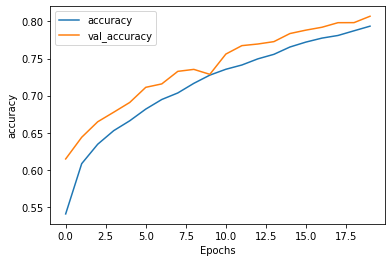

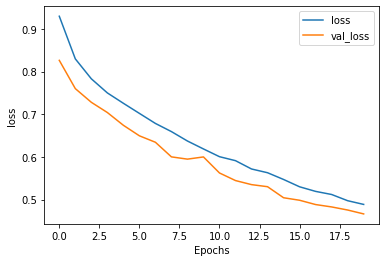

In [36]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [37]:
# store the model
model.save('my_sentiment_model.h5')

In [57]:
#mini test
import numpy as np
string = 'i feel so dismayed because i still have loads in miniature terms of weird pink clay left and didnt know what to do with it'
string = get_clean_text ('hola',string)
string = [string]
string = tokenizer.texts_to_sequences (string)
string = pad_sequences(string, maxlen=max_length, padding='post')
pred_string=model.predict(string) 
classes_x=(np.argmax(pred_string,axis=1)).item()
prediction_map ={0: 'Irrelevant', 1: 'Positive', 2: 'Negative'}
reply = prediction_map.get(classes_x)
reply

#{0: 'Irrelevant', 1: 'Positive', 2: 'Negative'}

'Negative'

In [52]:
df.iloc[1].text

'i feel passionate about people particularly those i love admire and respect'

In [56]:
df.iloc[2].text

'i feel so dismayed because i still have loads in miniature terms of weird pink clay left and didnt know what to do with it'

In [ ]:
# For future use

In [ ]:
def get_tone_text(text, upper = .3, exclamation = 3, terminals = "?!"):
    
    # remove whitespaces
    text = "".join(text.split())
    # if a third of the text is uppercase, then 1
    x_1 = int(sum(1 for c in text if c.isupper()) / sum(1 for c in text) > upper)
    # if more than  in text, 1 
    x_1 += int(sum(1 for c in text if c in terminals) > exclamation)
    
    return x_1

In [55]:
import nltk
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.2.5.
